## Import

In [9]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dadapy.data import Data
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from functions_IDEAS import compute_ID

## functions

In [22]:
def assign_label(cluster):
    cluster = str(cluster)
    if cluster in cluster_fibro:
        return 'fibro'
    elif cluster in cluster_partial:
        return 'partial'
    elif cluster in cluster_reprogramming:
        return 'reprogramming'
    else:
        return 'other'

In [23]:
def add_local_ID_to_adata(Adata,ID_dataframe):

    if 'local_ID' not in Adata.obs.columns:
        Adata.obs['local_ID'] = pd.NA 

    index = [item[0] for item in ID_dataframe.index]
    for barcode,id_val in zip(index, ID_dataframe.ID.values):
        Adata.obs.loc[Adata.obs_names == barcode, 'local_ID'] = id_val

    return Adata

In [31]:
def add_pseudotime_fibro(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmin(Adata_hv.obsm['X_diffmap'][:, 1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [25]:
def add_pseudotime_partial(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmin(Adata_hv.obsm['X_diffmap'][:,1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [26]:
def add_pseudotime_rep(Adata):
    
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    Adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(Adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(Adata_hv)
    Adata_hv.uns['iroot'] = np.argmax(Adata_hv.obsm['X_diffmap'][:,1])
    sc.tl.dpt(Adata_hv)

    # Transfer new annotations back to adata_rep
    Adata.obs['dpt_pseudotime'] = Adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = Adata_hv.obsm['X_diffmap']
    Adata.uns.update({k: Adata_hv.uns[k] for k in ['neighbors', 'diffmap_evals', 'iroot']})
    Adata.obsp = Adata_hv.obsp

    return Adata

In [27]:
def plot_clusters_boxplot(adata_ivf, adata_nt):

    adata_ivf.obs["local_ID"] = pd.to_numeric(adata_ivf.obs["local_ID"], errors="coerce")
    adata_nt.obs["local_ID"] = pd.to_numeric(adata_nt.obs["local_ID"], errors="coerce")

    adata_ivf.obs["Dataset"] = "IVF"
    adata_nt.obs["Dataset"] = "NT"

    combined_df = pd.concat([adata_ivf.obs, adata_nt.obs])
    clusters = sorted(combined_df["seurat_clusters"].unique())
    colors = sns.color_palette("tab10", 10)

    fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)  

    for i, cluster in enumerate(clusters):
        row, col = divmod(i, 5)  
        
   
        cluster_data = combined_df[combined_df["seurat_clusters"] == cluster]
        cluster_color = [colors[i]] * 2  

        sns.boxplot(data=cluster_data, x="Dataset", y="local_ID", ax=axes[row, col], palette=cluster_color)
        
        axes[row, col].set_title(f"Cluster {cluster}")
        axes[row, col].set_xlabel("")
        axes[row, col].set_ylabel("Local ID" if col == 0 else "")  
        axes[row, col].yaxis.grid(True)  

    plt.tight_layout()
    plt.show()


## Tran

In [38]:
# upload preprocessed data (with raw counts in the adata.X)
adata_fbs=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/FBS_IDEAS.h5ad')
adata_a2s=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/A2S_IDEAS.h5ad')

### FBS

In [39]:
# compute local ID for each cell
n_neighbors = 300
IDs_fbs = compute_ID(adata_fbs, method='local_2nn', n_samples = len(adata_fbs), n_neighbors = n_neighbors, full_output = True)
adata_fbs = add_local_ID_to_adata(adata_fbs, IDs_fbs)


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [18:20<00:00, 1100.15s/it]


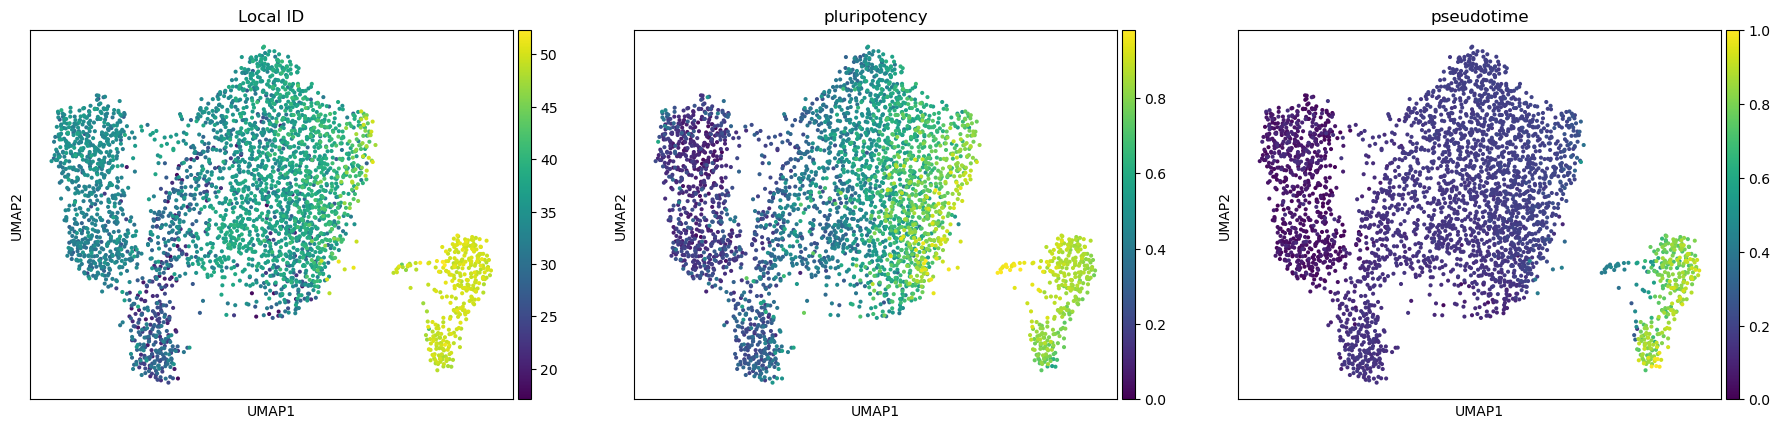

In [40]:

sc.pl.umap(adata_fbs, color=['local_ID', 'single_pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)
#adata_fbs.write('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/FBS_to_plot.h5ad')

### A2S

In [41]:
# compute local ID for each cell
n_neighbors = 300
IDs_a2s = compute_ID(adata_a2s, method='local_2nn', n_samples = len(adata_a2s), n_neighbors = n_neighbors, full_output = True)
adata_a2s = add_local_ID_to_adata(adata_a2s, IDs_a2s)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [11:49<00:00, 709.24s/it]


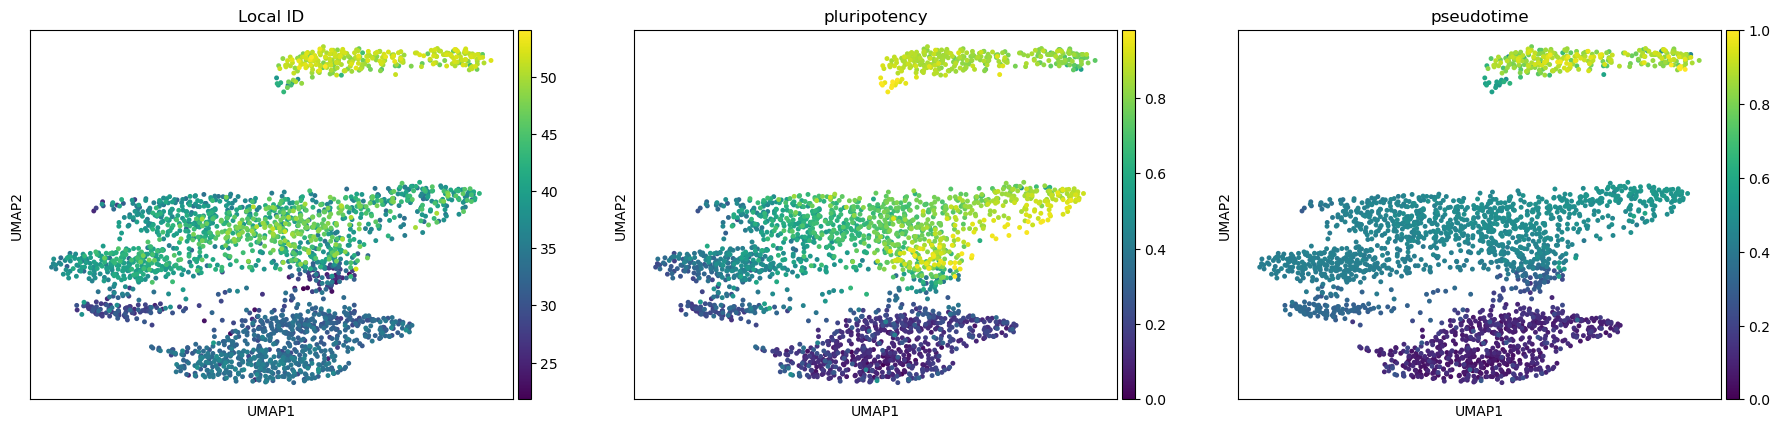

In [42]:
sc.pl.umap(adata_a2s, color=['local_ID', 'single_pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)
#adata_fbs.write('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/A2S_to_plot.h5ad')

## Nair 

In [87]:
# This is the code I ran to obtain the adata_nair_localID. Since it takes a long time, I saved it in Nair_local_ID.h5ad and use that for the following analysis.
'''
adata = sc.read('/Users/maddalenastaiano/Desktop/data/Nair.h5ad')

n_samples = 30000
n_neighbors = 600
IDs_nair = compute_ID(adata, method='local_2nn', n_samples = n_samples, n_neighbors = n_neighbors, full_output = True)
adata_nair_localID = add_local_ID_to_adata(adata, IDs_nair)'
'''

In [28]:
adata_nair_localID = sc.read('/Users/maddalenastaiano/Desktop/data/Nair_local_ID.h5ad')

In [32]:
# Divide the dataset in fibro, partial and reprogramming
cluster_fibro = ['1', '3', '4', '5']
cluster_partial = ['7', '9', '10']
cluster_reprogramming = ['8', '11', '12', '13', '14'] #cluster 15 is not included in the analysis 

adata_nair_localID.obs['trajectory'] = adata_nair_localID.obs['cluster'].apply(assign_label)

adata_fibro = adata_nair_localID[adata_nair_localID.obs.trajectory == 'fibro']
adata_partial = adata_nair_localID[adata_nair_localID.obs.trajectory == 'partial']
adata_rep = adata_nair_localID[adata_nair_localID.obs.trajectory == 'reprogramming']

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


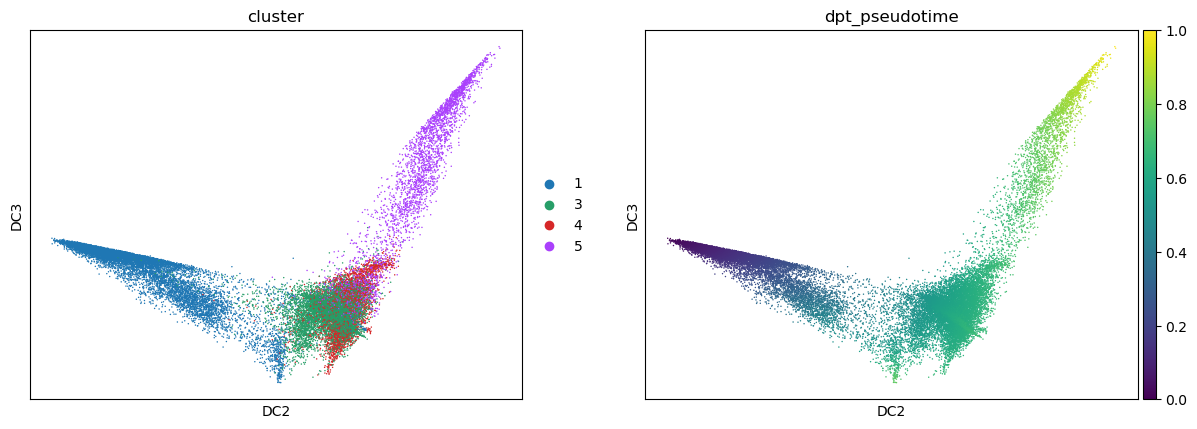

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

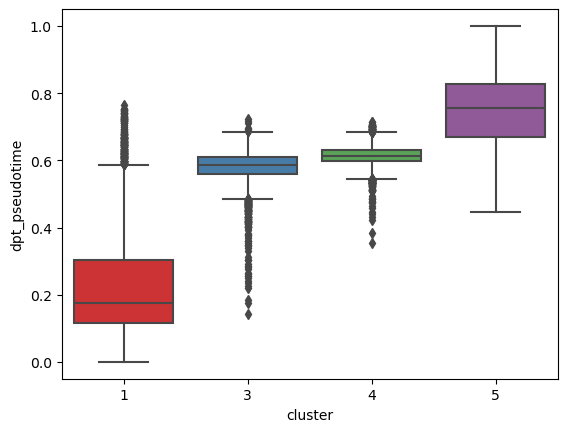

In [33]:
adata_fibro = add_pseudotime_fibro(adata_fibro)
sc.pl.diffmap(adata_fibro, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)]) #visualize pseudotime
sns.boxplot(data=adata_fibro.obs, x="cluster", y="dpt_pseudotime", palette='Set1') #check the correct ordering of clusters with psudotime 

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


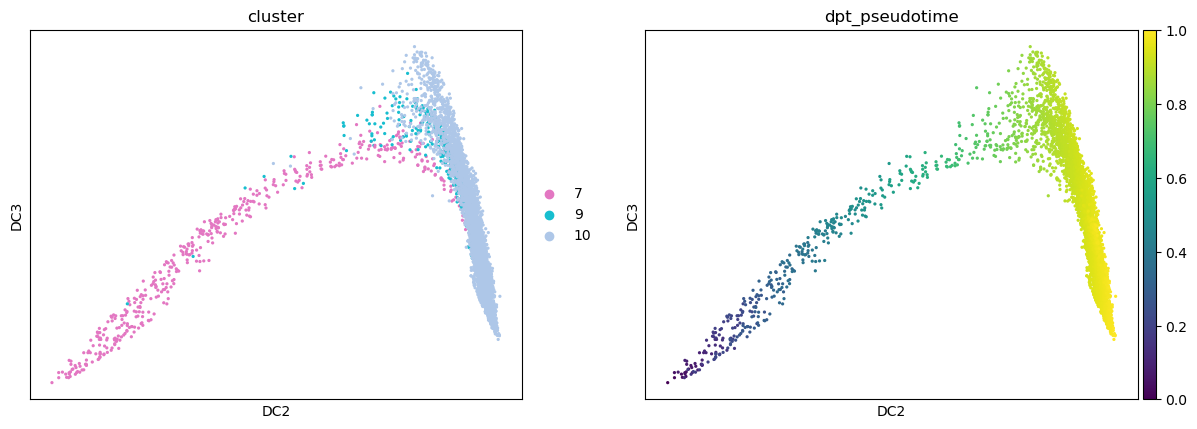

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

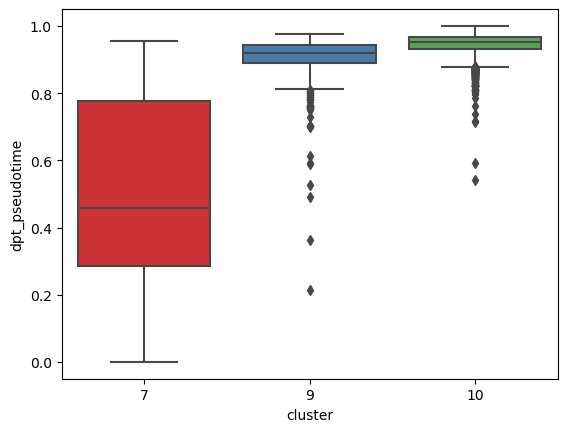

In [34]:
adata_partial = add_pseudotime_partial(adata_partial)
sc.pl.diffmap(adata_partial, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)])
sns.boxplot(data=adata_partial.obs, x="cluster", y="dpt_pseudotime", palette='Set1')

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


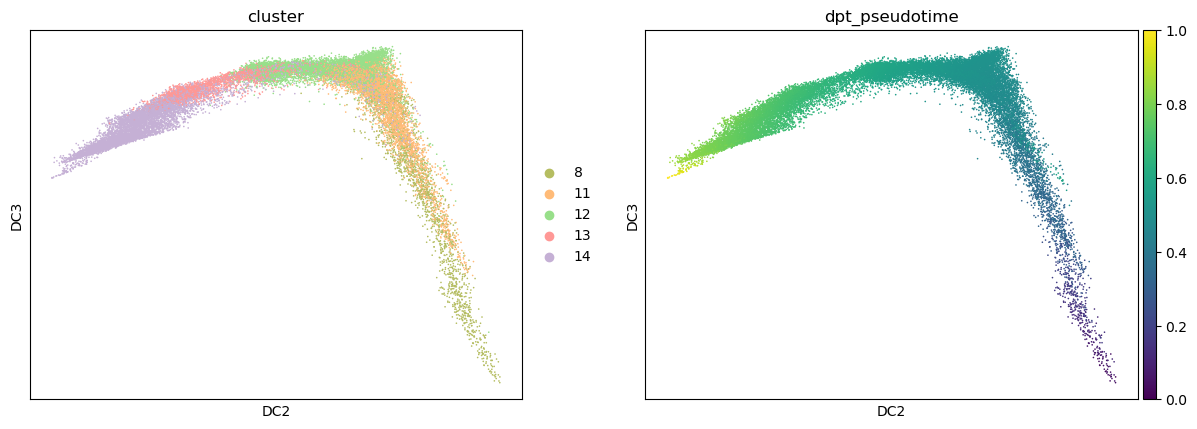

<Axes: xlabel='cluster', ylabel='dpt_pseudotime'>

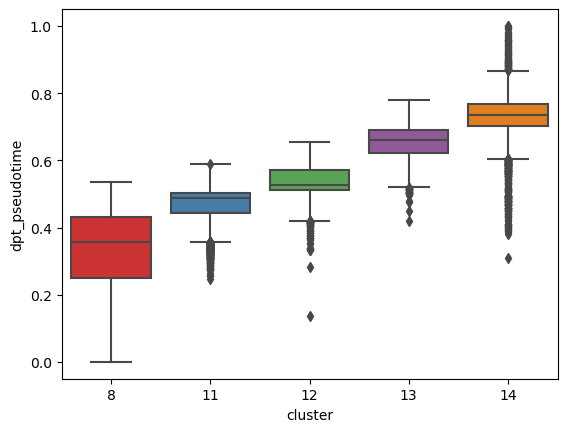

In [35]:
adata_rep = add_pseudotime_rep(adata_rep)
sc.pl.diffmap(adata_rep, color=['cluster','dpt_pseudotime'], dimensions=[(1, 2)])
sns.boxplot(data=adata_rep.obs, x="cluster", y="dpt_pseudotime", palette='Set1')

In [ ]:
# save results ready to plot
#adata_rep.write('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/Nair_REP_to_plot.h5ad')
#adata_fibro.write('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/Nair_FIBRO_to_plot.h5ad')
#adata_partial.write('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/Nair_PARTIAL_to_plot.h5ad')


## Xenopus

In [4]:
adata_xen = sc.read('/Users/maddalenastaiano/Desktop/data/xenopus_correct.h5ad')

In [5]:
adata_xen.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,isnt,integrated_snn_res.0.5,seurat_clusters
AAACCCAGTCTGCAAT.1,SIGAH5,37778.0,5842,SIGAH5,IVF,6,6
AAACGAACAAACCACT.1,SIGAH5,89539.0,8284,SIGAH5,IVF,0,0
AAACGCTAGGTTGTTC.1,SIGAH5,50225.0,6607,SIGAH5,IVF,3,3
AAACGCTCACTTGGCG.1,SIGAH5,60572.0,7252,SIGAH5,IVF,8,8
AAAGAACGTCAAAGAT.1,SIGAH5,53523.0,6700,SIGAH5,IVF,5,5
...,...,...,...,...,...,...,...
TTTACCATCCGTCCTA.1,SIGAB2,48420.0,8064,SIGAB2,NT,8,8
TTTCAGTGTACGATCT.1,SIGAB2,21383.0,5811,SIGAB2,NT,0,0
TTTCCTCCAGCCCAGT.1,SIGAB2,22628.0,5751,SIGAB2,NT,7,7
TTTGTTGCAAGTCGTT.1,SIGAB2,33055.0,7074,SIGAB2,NT,1,1


/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


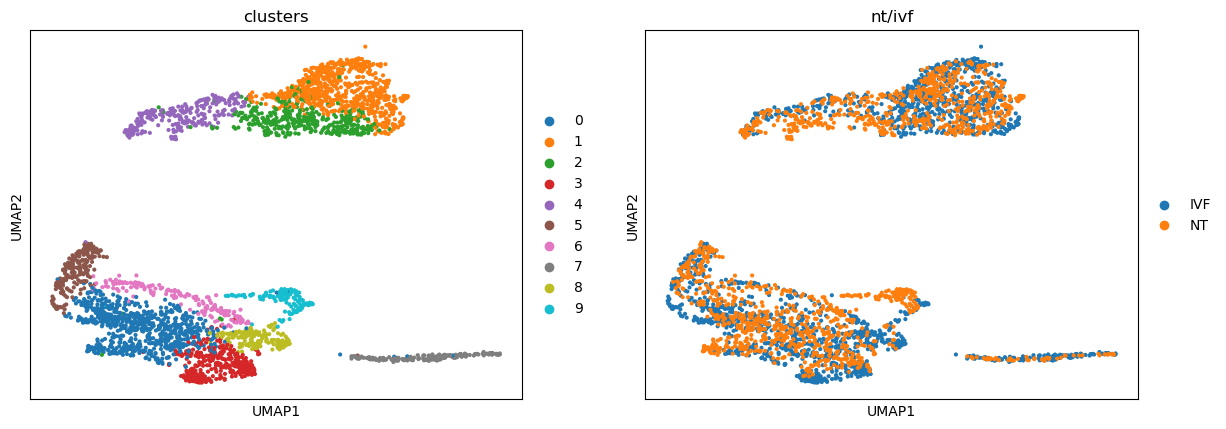

In [6]:
sc.pl.umap(adata_xen, color=['seurat_clusters', 'isnt'], title = ['clusters', 'nt/ivf'], alpha=1.)

In [7]:
adata_ivf = adata_xen[adata_xen.obs.isnt == 'IVF']
adata_nt = adata_xen[adata_xen.obs.isnt == 'NT']

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


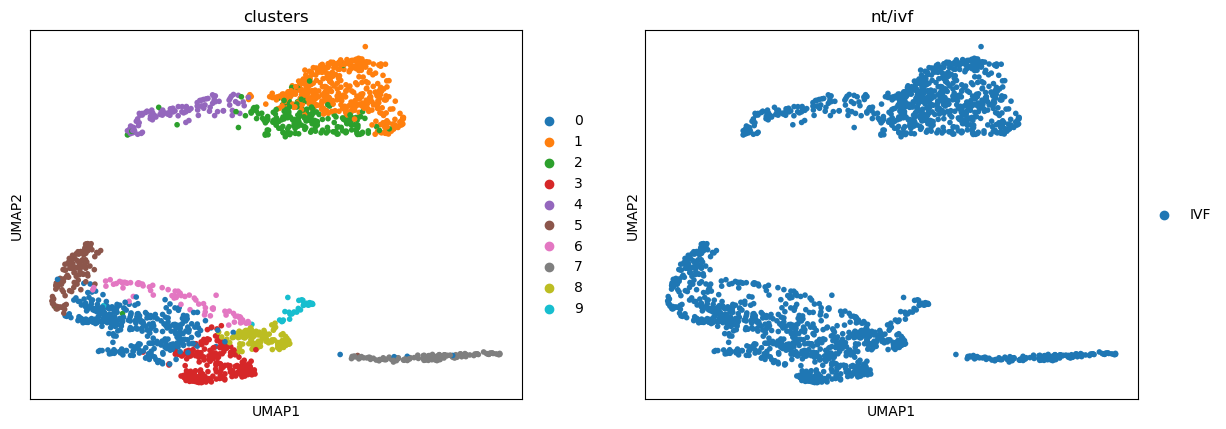

In [8]:
sc.pl.umap(adata_ivf, color=['seurat_clusters', 'isnt'], title = ['clusters', 'nt/ivf'], alpha=1.)

### ID separating IVT and NT cells

In [9]:
n_neighbors = 150
IDs_ivf = compute_ID(adata_ivf, method='local_2nn', n_samples = len(adata_ivf), n_neighbors = n_neighbors, full_output = True)
IDs_nt = compute_ID(adata_nt, method='local_2nn', n_samples = len(adata_nt), n_neighbors = n_neighbors, full_output = True)
adata_ivf = add_local_ID_to_adata(adata_ivf,IDs_ivf)
adata_nt = add_local_ID_to_adata(adata_nt,IDs_nt)

Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [05:14<00:00, 314.71s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_72815/3912101523.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['local_ID'] = pd.NA
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_72815/3912101523.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['local_ID'] = pd.NA


In [10]:
print(f'IVF  -->  min value: {IDs_ivf.ID.values.min()}      max value {IDs_ivf.ID.values.max()} ')
print(f'NT  -->  min value: {IDs_nt.ID.values.min()}      max value {IDs_nt.ID.values.max()} ')
minvalue = min(IDs_ivf.ID.values.min(), IDs_nt.ID.values.min())
maxvalue = max(IDs_ivf.ID.values.max(), IDs_nt.ID.values.max())
print(f'min : {minvalue}, max : {maxvalue}')


IVF  -->  min value: 16.481102233085977      max value 43.93337771602801 
NT  -->  min value: 4.254108872240635      max value 46.056525202158724 
min : 4.254108872240635, max : 46.056525202158724


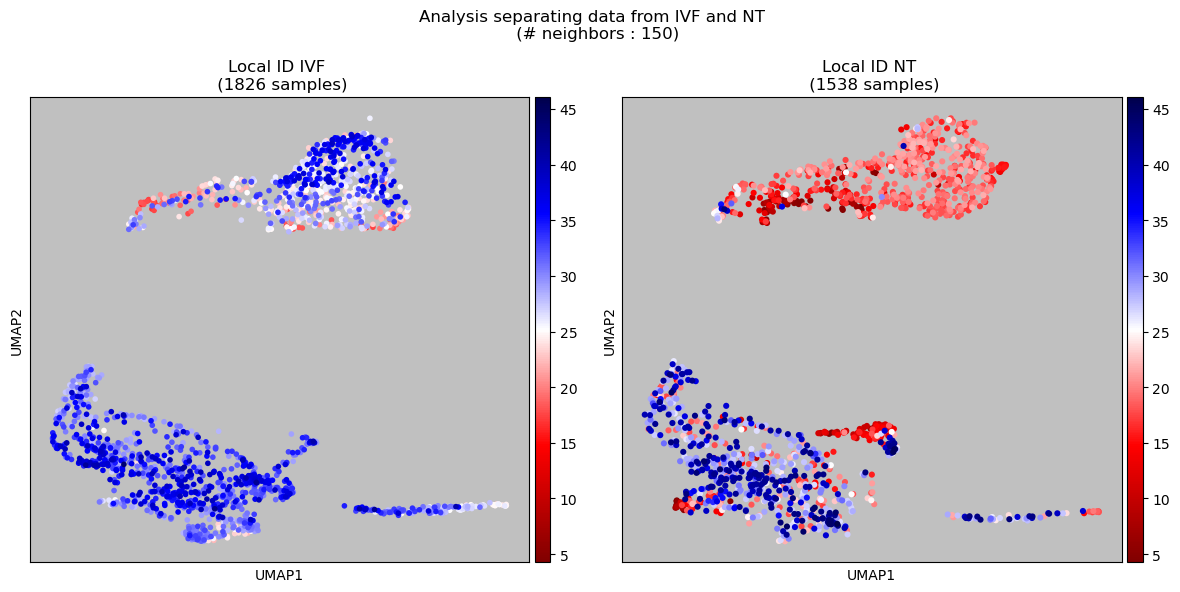

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Analysis separating data from IVF and NT \n (# neighbors : 150)')

axes[0].set_facecolor('silver')
axes[1].set_facecolor('silver')

sc.pl.umap(adata_ivf, color='local_ID', title='Local ID IVF \n (1826 samples)', color_map='seismic_r', alpha=1., ax=axes[0], show=False, vmin = minvalue, vmax = maxvalue)
sc.pl.umap(adata_nt, color='local_ID', title='Local ID NT \n (1538 samples)', color_map='seismic_r', alpha=1., ax=axes[1], show=False, vmin = minvalue, vmax = maxvalue)

plt.tight_layout()
plt.show()

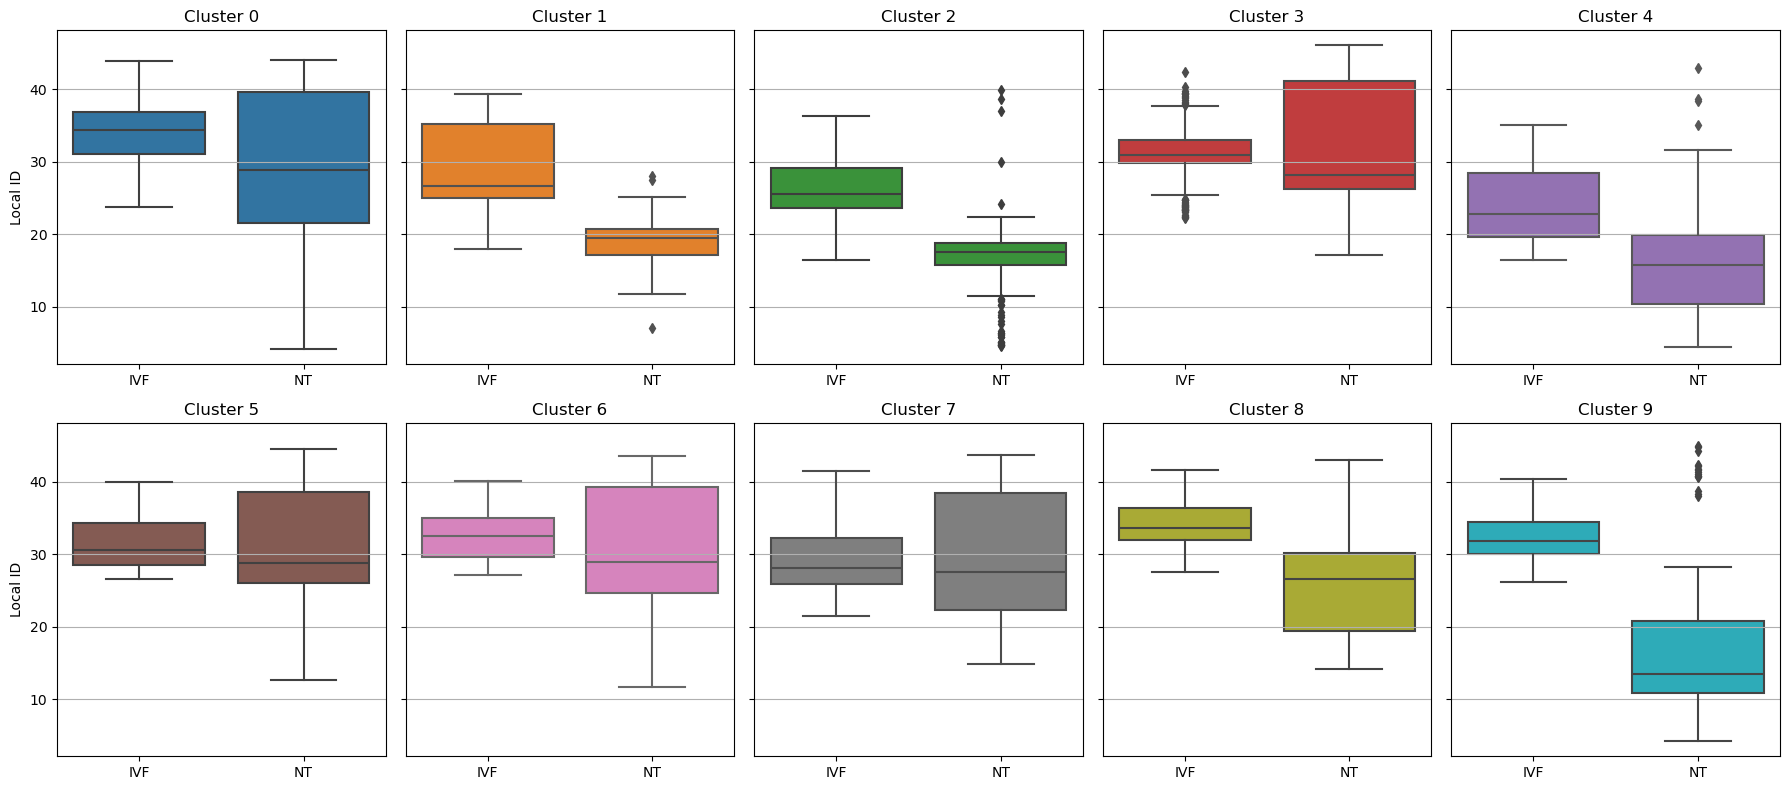

In [12]:
plot_clusters_boxplot(adata_ivf, adata_nt)

### ID on all cells together

In [72]:
n_neighbors = 150
IDs_xen = compute_ID(adata_xen, method='local_2nn', n_samples = len(adata_xen), n_neighbors = n_neighbors, full_output = True)


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID for all ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [17:35<00:00, 1055.75s/it]


In [75]:
add_local_ID_to_adata(adata_xen, IDs_xen)

AnnData object with n_obs × n_vars = 3364 × 31179
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'isnt', 'integrated_snn_res.0.5', 'seurat_clusters', 'local_ID'
    var: 'features'
    uns: 'isnt_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [80]:

adata_xen_ivf = adata_xen[adata_xen.obs.isnt == 'IVF']
adata_xen_nt = adata_xen[adata_xen.obs.isnt == 'NT']

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30531/1636491519.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ivf.obs["local_ID"] = pd.to_numeric(adata_ivf.obs["local_ID"], errors="coerce")
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_30531/1636491519.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nt.obs["local_ID"] = pd.to_numeric(adata_nt.obs["local_ID"], errors="coerce")


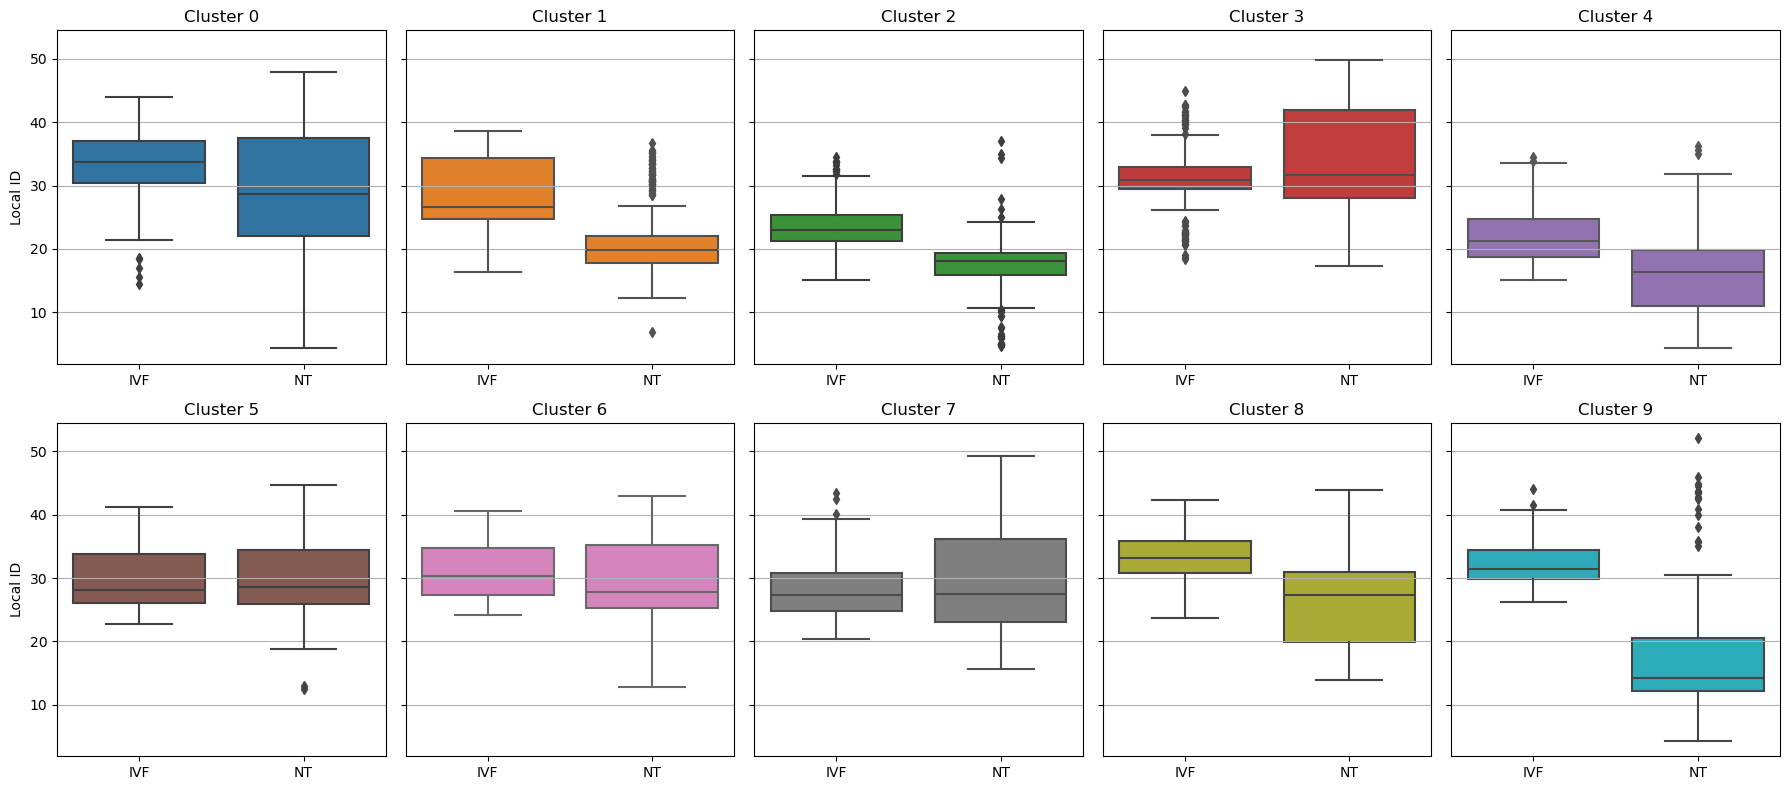

In [81]:
plot_clusters_boxplot(adata_xen_ivf, adata_xen_nt)

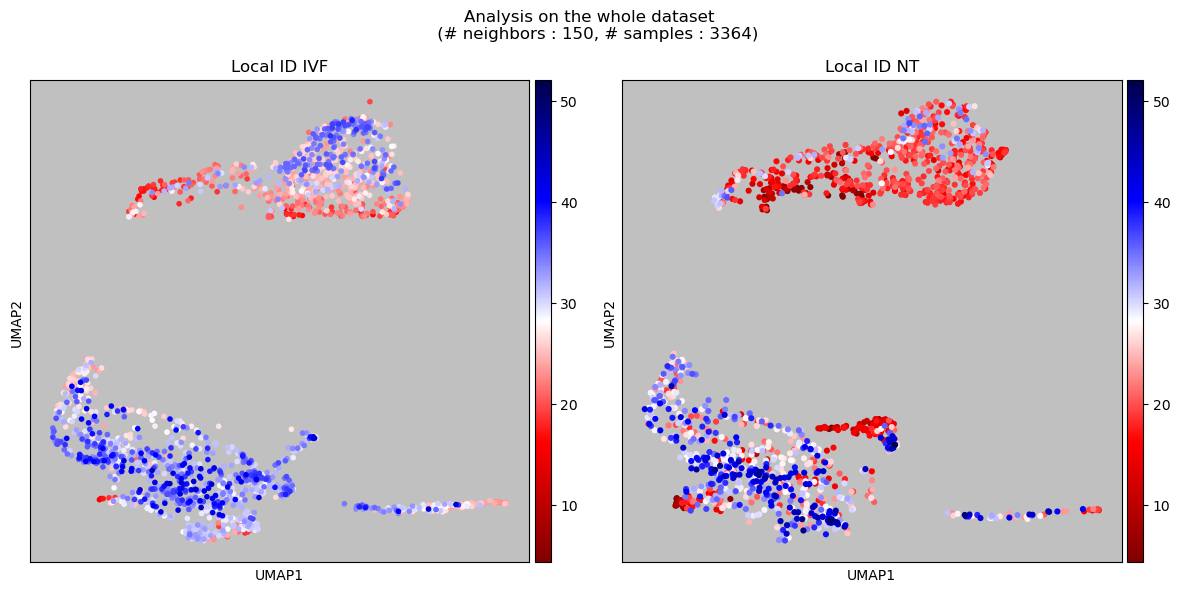

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Analysis on the whole dataset  \n (# neighbors : 150, # samples : 3364)')

axes[0].set_facecolor('silver')
axes[1].set_facecolor('silver')

min = IDs_xen.ID.values.min()
max = IDs_xen.ID.values.max()
sc.pl.umap(adata_xen[adata_xen.obs.isnt == 'IVF'], color='local_ID', title='Local ID IVF', color_map='seismic_r', alpha=1., ax=axes[0], show=False, vmin = min,  vmax = max)
sc.pl.umap(adata_xen[adata_xen.obs.isnt == 'NT'], color='local_ID', title='Local ID NT', color_map='seismic_r', alpha=1., ax=axes[1], show=False, vmin = min,  vmax = max)

plt.tight_layout()
plt.show()

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_89276/2540953238.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


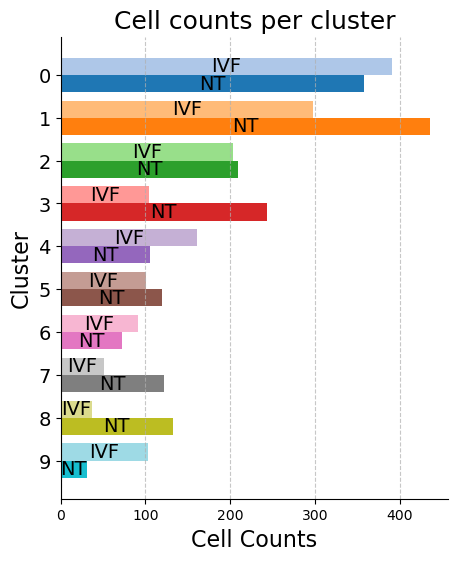

In [119]:
# cell counts per cluster

clusters, counts_NT =  np.unique(adata_xen[adata_xen.obs['isnt']=='NT'].obs['seurat_clusters'], return_counts = True)
clusters, counts_IVF = np.unique(adata_xen[adata_xen.obs['isnt']=='IVF'].obs['seurat_clusters'], return_counts = True)
x = np.arange(len(clusters))
l = 0.4
colors = plt.cm.get_cmap('tab20', 20)  
odd_indices = np.arange(1, 20, 2)
even_indices = np.arange(0, 20, 2)

plt.figure(figsize=(5, 6)) 
bars_NT = plt.barh(x - l/2, counts_NT, height=l, color=colors(odd_indices))
bars_IVF = plt.barh(x + l/2, counts_IVF, height=l, color=colors(even_indices))

plt.gca().invert_yaxis()

plt.xlabel("Cell Counts", fontsize=16)  
plt.ylabel("Cluster", fontsize=16)  
plt.title("Cell counts per cluster", fontsize=18)  

for bar in bars_NT:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 'IVF', va='center', ha='center', fontsize=14, color='black')

for bar in bars_IVF:
    plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, 'NT', va='center', ha='center', fontsize=14, color='black')

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.yticks(np.arange(0, 10, 1), fontsize=14)  
sns.despine()
plt.show()
